# Generating background lidar signal

In [1]:
from datetime import datetime, timedelta, time
import os,inspect
import sys
import glob
import matplotlib
import mpld3
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
#mpld3.enable_notebook()
import random
import numpy as np
import scipy as sp
import pandas as pd
import yaml
import cv2
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
import miscLidar as mscLid
from miscLidar import LidarProfile,RadiosondeProfile
from molecular import rayleigh_scattering
from constsLidar import *
from pytictoc import TicToc
ticker = TicToc()
out_dir = os.path.join(os.path.dirname(os.getcwd()),'Figures')

<ipython-input-1-1aed013fd5f8>:17: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


This Notebook uses background statistics of the Lidar measurements in Haifa from 04-Apr-2017.

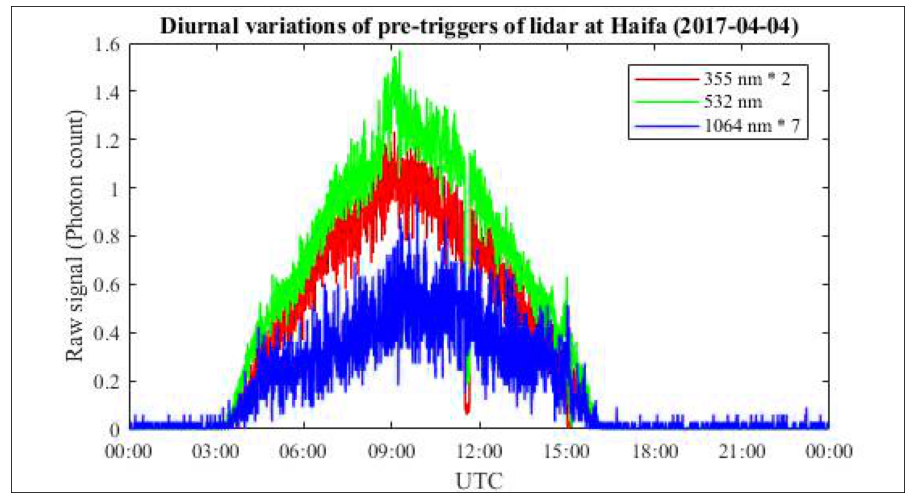

In [2]:
bg_signal_folder = os.path.join(os.getcwd(),'background_signal')
bg_origin_I = cv2.imread(os.path.join(bg_signal_folder,'background_noise.jpg'))

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(16, 12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(bg_origin_I)
plt.show()

## Workflow
1. Generating samples {time_stamp, value} of the plots in the figure above,
using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/).
The measurements represent the higher and lower bounds of each channel's plot (UV,G,IR).
5. For each of the datasets calculating a semi-automatic curve fit, using [chart-studio](https://chart-studio.plotly.com/create/#/) .
The Gaussian curve seems roughly appropriate, therefore selected. The model is:

> $\qquad \qquad \qquad \qquad \qquad \qquad {y = A+H\cdot \exp\bigg(-\dfrac{(t-t_0)^2}{2 W^2}\bigg)}$

> Parameters meanings:

>>$A$: Bias term (above x-axis)
>>
>>$H$: The height of Gaussian curve
>>
>>$t_0$: The center of the Gaussian lobe
>>
>>$W$: The width of Gaussian lobe


>Notes:
>
>a. The x-axis params ($t_0$, $W$) should be normalized according to a ratio between the x-axis used here the resolution used in plotly.
>
>b. I assume that it would be possible to roughly simulate background light through the year, by adapting $t_0$ and $W$ to the [sunrise and sunset](https://www.timeanddate.com/astronomy/israel/haifa) times per day.
Also, this assumption would likely suit a simple case of a clear sky.
E.g., clouds and fog effect background light (however, practically this can be controlled by adapting H).
>
>c. The sampled values of the original plots are presented in the next figure as dots, anThe curves represent the bounding Gaussians.

3. Generating a new **averaged** background signal using a normal distribution, which takes the average and distance
between each pair of high/low curves as mean and std values.


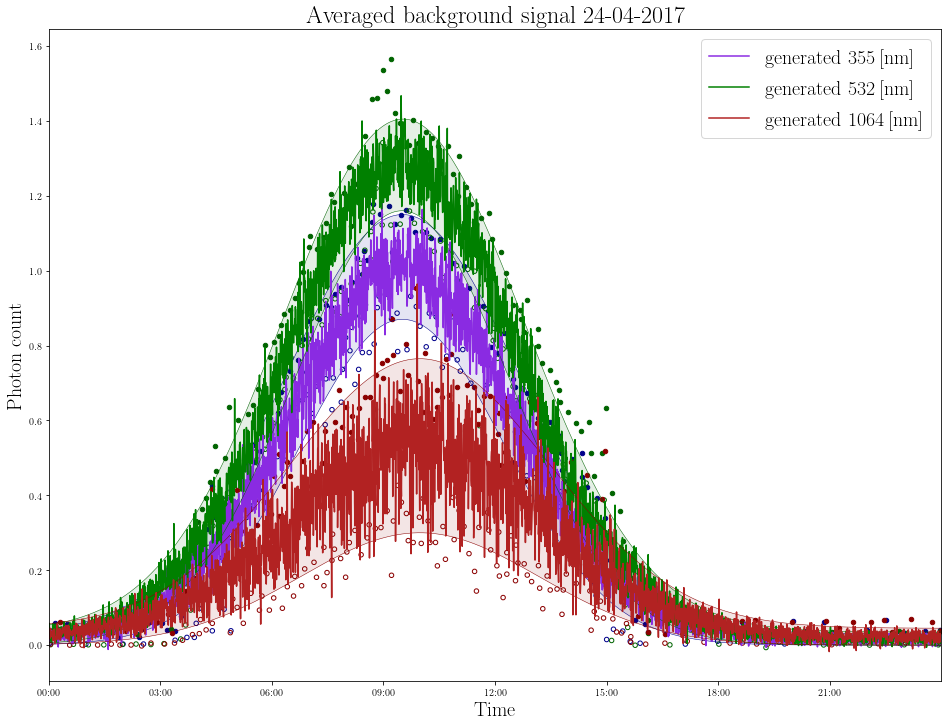

In [3]:
channels =['UV','G','IR']

'''Load samples of the plots in the original image: '''
bg_meas_path = os.path.join(bg_signal_folder,'bg_signal_measurments.csv')#'high_blue_meas.csv'
bg_meas_df = pd.read_csv(bg_meas_path, delimiter=",",sep="\t",
                         encoding='unicode_escape', skiprows=None,parse_dates=True)

'''Load parameters of gaussian curve fit:'''
bg_params_path = os.path.join(bg_signal_folder,'curve_params.yml')
with open(bg_params_path,'r') as ymlfile:
        params = yaml.safe_load(ymlfile)

'''time resolution staff'''
delta_t = 30 # [sec]
bins_per_hr = np.int(60*60/delta_t)
bins_per_day = 24*bins_per_hr
t = np.arange(0,bins_per_day) # time axis
#  The ratio is to adjust time bins (t) to lidar sampling bins (delta_t=30[s] ) ; the estimated curve refer to delta_t=100[s], bins_per_day=864
bins_ratio = bins_per_day/params['bins_per_day']

'''generate background signal'''
bg_new = []
#mean_curves = []
high_curves =[]
low_curves =[]
for chan in channels:
    prms_h = params[chan]['high']
    prms_l = params[chan]['low']

    ''' Calculating bounding curves series'''
    high_curve = mscLid.calc_gauss_curve(t,prms_h['A'],prms_h['H'],bins_ratio*prms_h['t0'],bins_ratio*prms_h['W'])
    low_curve = mscLid.calc_gauss_curve(t,prms_l['A'],prms_l['H'],bins_ratio*prms_l['t0'],bins_ratio*prms_l['W'])
    high_curves.append(high_curve)
    low_curves.append(low_curve)
    ''' Generating new random series of background signal'''
    mean_val = 0.5*(low_curve+high_curve)
    #mean_tmp = np.mean()
    std_val = 0.25*(high_curve-low_curve)
    bg_new_chan = mean_val.reshape(bins_per_day,1)+\
                  np.matmul(np.diagflat(std_val),np.random.randn(bins_per_day,1))
    bg_new.append(bg_new_chan)#(bg_new_chan)

'''Create a background figure for the curves above:'''
vis_bg_new=True
timeformat = mdates.DateFormatter('%H:%M')
if vis_bg_new:
    t_times = []
    x_lims = []
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(16, 12))

    for (chan,bg_chan,curve_h,curve_l) in zip(channels,bg_new,high_curves,low_curves):
    #chan = channels[0]
        # measurements of upper bound
        pref_h = '{}_high'.format(chan)
        sub_df_high =  bg_meas_df[['{}_times'.format(pref_h),'{}_vals'.format(pref_h)]].dropna()
        times_h= [pd.Timestamp(t).to_pydatetime() for t in sub_df_high['{}_high_times'.format(chan)].values]
        bg_vals_h = sub_df_high['{}_high_vals'.format(chan)].values

        # measurements of lower bound
        pref_l = '{}_low'.format(chan)
        sub_df_low =  bg_meas_df[['{}_times'.format(pref_l),'{}_vals'.format(pref_l)]].dropna()
        times_l= [pd.Timestamp(t).to_pydatetime() for t in sub_df_low['{}_low_times'.format(chan)].values]
        bg_vals_l = sub_df_low['{}_vals'.format(pref_l)].values

        lambda_um= getattr(LAMBDA, chan)*1e+9
        lambda_s = r'generated ${0:.0f}\,\rm [nm]$'.format(lambda_um)
    # plot
        if (x_lims is not None) and (t_times is not None):
                x_lims = [datetime.combine(times_h[0].date(),datetime.min.time()),
                          datetime.combine(times_h[0].date(),datetime.max.time())]
                t_times = mscLid.create_times_list(x_lims[0], x_lims[1], delta_t, type_time ='seconds')

        ax.plot(t_times,curve_h,color=params[chan]['C'],linewidth=0.5)#, label=None)#'upper bound curve')
        ax.plot(t_times,curve_l,color=params[chan]['C'],linewidth=0.5)#,label='lower bound curve')
        ax.fill_between(t_times, curve_h, curve_l,  facecolor=params[chan]['C'], alpha=0.1)
        ax.scatter(times_h,bg_vals_h,color=params[chan]['C'],s=20)#,label='meas. high') # trial to do set_clim : c =np.ones(np.shape(bg_vals_h))*0.7 + 0.3*bg_vals_h,  cmap =plt.cm.Greens)
        ax.scatter(times_l,bg_vals_l,color=params[chan]['C'],s=20,facecolor='none') #,label='meas. low') # c=np.ones(np.shape(bg_vals_l))*0.5 + 0.3*bg_vals_l,facecolors='None',  cmap = plt.cm.Greens)
        ax.plot(t_times,bg_chan,color=params[chan]['C_new'],label=lambda_s)
        #ax.plot(t_times,mean_curve,color='cyan',label='mean curve')

    stitle = 'Averaged background signal 24-04-2017'
    ax.set_title(stitle,fontsize =24,fontweight='bold')
    x_lims = mdates.date2num(x_lims)
    ax.set_xlim(x_lims)
    #timeformat = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(timeformat)
    ax.set_xlabel('Time',fontsize =20,fontweight='bold')
    ax.set_ylabel('Photon count',fontsize =20,fontweight='bold')
    plt.rc('xtick',labelsize =18)
    plt.rc('ytick',labelsize=18)
    legend_properties = {'weight':'bold','size':20} #,'edgecolor':0}
    ax.legend(prop= legend_properties)#fontsize=14)
    fig.set_constrained_layout = True
    plt.show()

    save_fig= False
    if save_fig:
        sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
        fig.savefig(sfname,bbox_inches='tight',dpi=700)
        print('Figure saved at ',sfname)

4. Generating photon counts, by sampling from a Poisson distribution having the average that presented above.
 For each time-stamp, the number of sampling events is as the lidars' bins counts (a.k.a height bins).
>> Note: The figure below presents photon counts for 10% of the bins (randomly chosen).

In [4]:
'''Sample from a Poisson distribution.'''
dr = 7.5e-3 # dr = 7.5[m] = 7.5e-3[km]
top_height = 10.1 # [km]
heights = np.arange(min_height,top_height,dr)
n_heights = heights.shape[0]
bg_photons= [] #np.zeros((3,len(t),n_heights))
#ticker.tic()
for bg_c in bg_new:
    poiss_c = \
        np.array([mscLid.generate_poisson_signal(mu= mu_k,n= n_heights) for mu_k in bg_c]).T
    #trsnsposing, since bg_new has column stack values throughout the day (axis 0), however the time axis of lidar is 1
    bg_photons.append(poiss_c)
#ticker.toc()
#print(poiss_c.shape)

In [5]:
'''
plt.figure()
for chan, bg_chan in zip(channels,bg_photons):
	mean_chan  = np.mean(bg_chan,axis=0)
	plt.plot(t_times,mean_chan,color=params[chan]['C'])
plt.show()
'''

"\nplt.figure()\nfor chan, bg_chan in zip(channels,bg_photons):\n\tmean_chan  = np.mean(bg_chan,axis=0)\n\tplt.plot(t_times,mean_chan,color=params[chan]['C'])\nplt.show()\n"

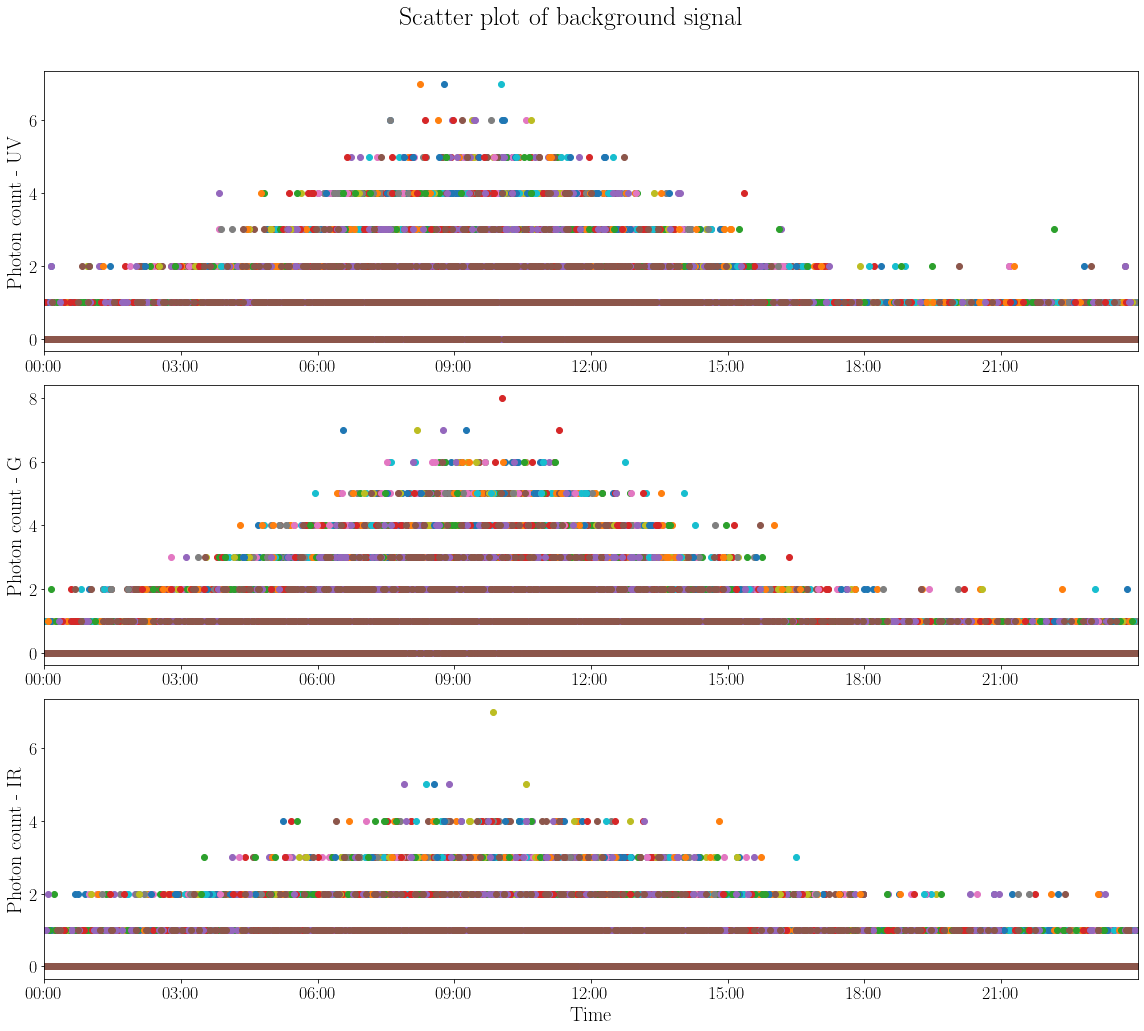

Figure saved at  C:\Users\addalin\Dropbox\Lidar\Figures\Scatter plot of background signal.png


In [6]:
'''Scatter plot of signal'''
#ticker.tic()
stitle ='Scatter plot of background signal'
fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(16, 14))
fig.suptitle(stitle,fontsize =26,fontweight='bold',y=1.02)
for ax,bg_c,chan in zip(axes,bg_photons,channels):
    for h in random.sample(np.arange(n_heights).tolist(),np.int(np.round(n_heights*.05))):
        y = bg_c[h,:]
        #plt.scatter(t,y)
        ax.scatter(t_times,y)
        ax.xaxis.set_major_formatter(timeformat)
        ax.set_xlim(x_lims)
        ax.set_ylabel('Photon count - {}'.format(chan),fontsize =20,fontweight='bold')

ax.set_xlabel('Time',fontsize =20,fontweight='bold')
fig.tight_layout()

plt.show()
#ticker.toc()
save_fig= True
if save_fig:

    sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
    fig.savefig(sfname,bbox_inches='tight',dpi=700)
    print('Figure saved at ',sfname)

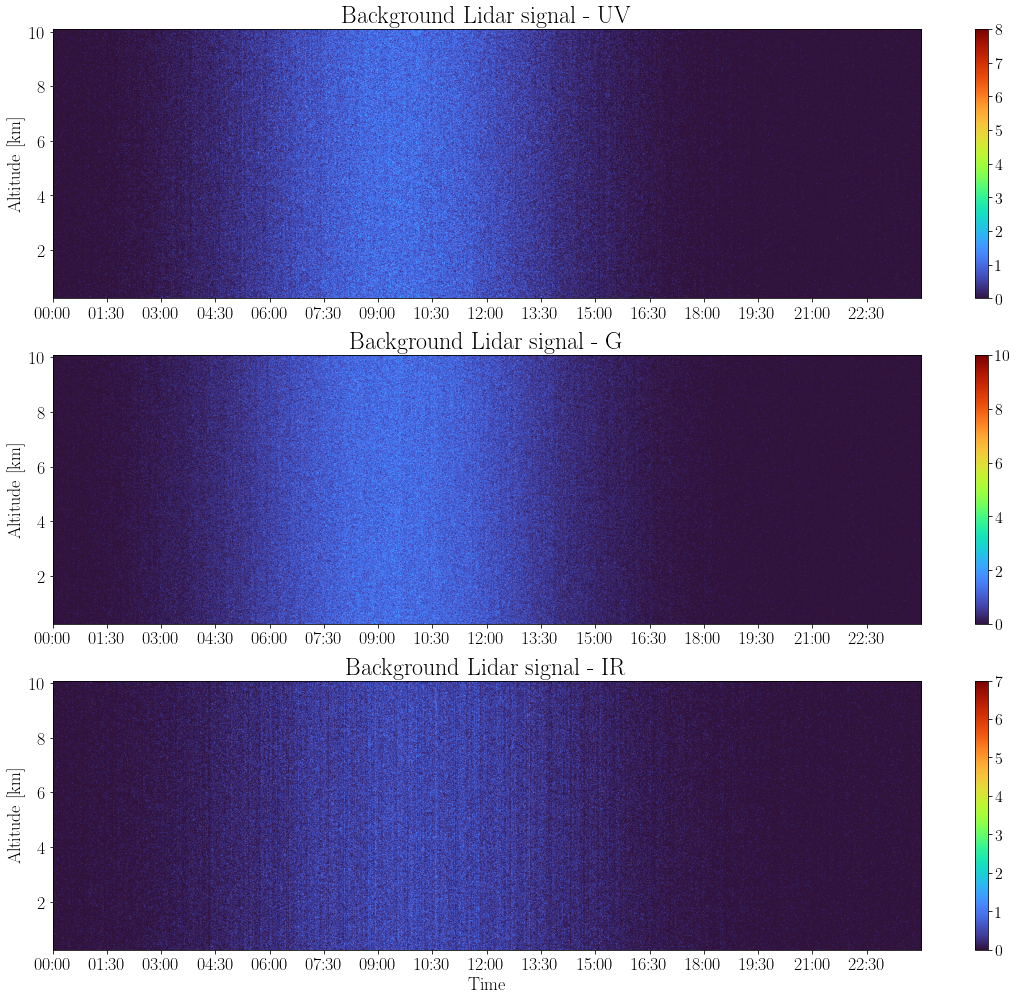

In [7]:
datatime_start = datetime(2017,4,22,0,0)
datatime_end = datetime(2017,4,22,23,59,30)
delta_t = 30 # [seconds]
times_seconds = mscLid.create_times_list(datatime_start, datatime_end, delta_t, 'seconds')
x_lims = [times_seconds[0],times_seconds[-1]]
x_lims = mdates.date2num(x_lims)
y_lims = [heights[0],heights[-1]]
xfmt = mdates.DateFormatter('%H:%M')
stitle = 'Background Lidar signal'
vis_power_bg=True
if vis_power_bg:
    fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(16, 14))
    for ax,bg_c,chan in zip(axes,bg_photons,channels):
        im = ax.imshow(bg_c,extent= [x_lims[0],x_lims[1],y_lims[-1],y_lims[0]],
                       aspect='auto',cmap = 'turbo')
        ax.invert_yaxis()
        ax.xaxis_date()
        ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=90))
        ax.xaxis.set_major_formatter(xfmt)
        ax.set_ylabel('Altitude [km]',fontsize =18)
        ax.set_title(stitle+' - {}'.format(chan),fontsize =24,fontweight='bold')
        plt.rc('xtick',labelsize =14)
        plt.rc('ytick',labelsize=16)
        fig.colorbar(im,ax= ax)
    ax.set_xlabel('Time',fontsize =18)
    fig.tight_layout()
    plt.show()

    save_fig= False
    if save_fig:
        sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
        fig.savefig(sfname,bbox_inches='tight',dpi=700)
        print('Figure saved at ',sfname)


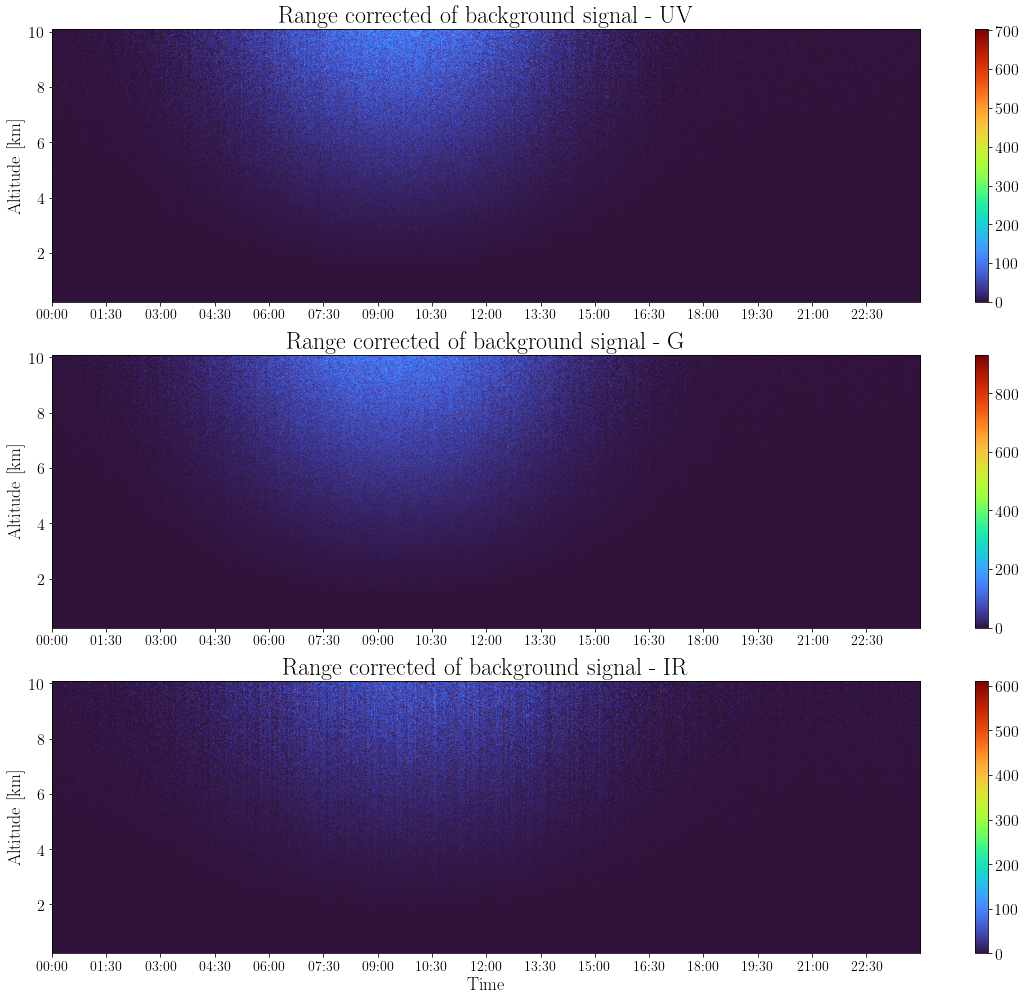

In [8]:
stitle = 'Range corrected of background signal'
vis_power_bg=True
if vis_power_bg:
    fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(16, 14))
    for ax,bg_c,chan in zip(axes,bg_photons,channels):
        S_bg = mscLid.calc_S(heights,bg_c)
        im = ax.imshow(S_bg,extent= [x_lims[0],x_lims[1],y_lims[-1],y_lims[0]],
                       aspect='auto',cmap = 'turbo')
        ax.invert_yaxis()
        ax.xaxis_date()
        ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=90))
        ax.xaxis.set_major_formatter(xfmt)
        ax.set_ylabel('Altitude [km]',fontsize =18)
        ax.set_title(stitle+' - {}'.format(chan),fontsize =24)
        plt.rc('xtick',labelsize =14)
        plt.rc('ytick',labelsize=16)
        fig.colorbar(im,ax= ax)
    ax.set_xlabel('Time',fontsize =18)
    fig.tight_layout()
    plt.show()

    save_fig= False
    if save_fig:
        sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
        fig.savefig(sfname,bbox_inches='tight',dpi=700)
        print('Figure saved at ',sfname)

In [9]:
len(times_seconds)

2880